# Homework 2
## Extracting TopUniversities and TimesHigherEducation Data

## Library

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn
import unicodedata
import re
from IPython.core.display import display
%matplotlib inline

## Vars

In [2]:
web_urls = [{'page':'https://www.topuniversities.com',
             'data':'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt'},
            {'page':'https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/stats',
             'data':'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'}]

#reading from pickle, avoid generating to many redundant traffic
qs_top200 = pd.read_pickle("qs_top200_pickle")
times_top200 = pd.read_pickle("times_top200_pickle")


## Functions

In [3]:
def get_number_elements(htmlPage, className):
    try:
        number = int(((htmlPage.find('div', class_=className)).find('div', class_="number").text).replace(',',''))    
    except AttributeError:
        number = 0
    return number

def crawl_topuniversities(url,n_top):
    http_response = requests.get(url['data'])
    universities = http_response.json()['data'][:n_top]
    list_universities = []
    for idx,university in enumerate(universities):
        
        university_region = university['region']
        university_country = university['location']
        university_rank = (int)(university['overall_rank'])
        
        university_info_html = BeautifulSoup(university['uni'], 'html.parser')
        link_element = university_info_html.find('a')
        
        university_name = link_element.text
        university_link = link_element.get('href')

        university_detail = requests.get(url['page']+university_link)
        university_detail_html = BeautifulSoup(university_detail.text, 'html.parser')
        
        n_f_members = get_number_elements(university_detail_html,"total faculty")    
        n_inter_f_members = get_number_elements(university_detail_html,"inter faculty") 
        
        n_students = get_number_elements(university_detail_html,"total student") 
        n_inter_students = get_number_elements(university_detail_html,"total inter") 
        
        university_data = ({
                                'rank': university_rank,
                                'university_name': university_name,
                                'country': university_country,
                                'region': university_region,
                                'total_faculty_members': n_f_members,
                                'total_international_faculty_members': n_inter_f_members,
                                'total_students': n_students,
                                'total_international_students': n_inter_students
                          })
        list_universities.append(university_data)
    
    universities = pd.DataFrame.from_dict(list_universities)
    
    return universities

def crawl_timeshighereducation(url,n_top):
    http_response = requests.get(url['data'])
    universities = http_response.json()['data'][:n_top]
    list_universities = []
    for university in universities:
        
        university_rank = (int)(university['rank'].replace('=',''))
        university_name = university['name']
        university_country = university['location']
        n_students = int(university['stats_number_students'].replace(',',''))
        student_staff_ratio = float(university['stats_student_staff_ratio'])
        inter_student_percentage = float(university['stats_pc_intl_students'].strip('%'))/100 
        
        university_data = ({
                                'rank': university_rank,
                                'university_name': university_name,
                                'country': university_country,
                                'student_staff_ratio': student_staff_ratio,
                                'percentage_international_students': inter_student_percentage,
                                'total_students': n_students
                          })
        list_universities.append(university_data)
        
    universities = pd.DataFrame.from_dict(list_universities)
    return universities   

def group_df(df,group_category,agg):
    return df.groupby(group_category).university_name.agg([agg])

def convert_string(string):
    str_byte = unicodedata.normalize("NFKD",string).encode('ascii','ignore')
    string_ascii = str_byte.decode("utf-8", "strict")
    string_without_parentheses = (re.sub(r'\([^)]*\)', '', string_ascii)).strip()
    return string_without_parentheses

def df_convert_index(df):
    new_index = pd.Series(list(map(convert_string,df['university_name'])))
    new_df = df.drop(['university_name'],axis=1)
    new_df['university_name'] = new_index
    new_df = new_df.set_index(['university_name'])
    return new_df

## Main Homework

# 1.Analysis of Top Universities Data

In [4]:
qs_top200 = crawl_topuniversities(web_urls[0],200)

In [5]:
qs_top200.head()

,country,rank,region,total_faculty_members,total_international_faculty_members,total_international_students,total_students,university_name
0,United States,1,North America,2982,1679,3717,11067,Massachusetts Institute of Technology (MIT)
1,United States,2,North America,4285,2042,3611,15878,Stanford University
2,United States,3,North America,4350,1311,5266,22429,Harvard University
3,United States,4,North America,953,350,647,2255,California Institute of Technology (Caltech)
4,United Kingdom,5,Europe,5490,2278,6699,18770,University of Cambridge


#### 1a. Best Universities: Ratio Faculty Members / Students

In [6]:
f_members_students_r = pd.DataFrame(qs_top200.university_name)
f_members_students_r["faculty_member_student_ratio"] = (qs_top200.total_faculty_members/qs_top200.total_students)
f_members_students_r.sort_values("faculty_member_student_ratio",ascending=False).head(3)

,university_name,faculty_member_student_ratio
3,California Institute of Technology (Caltech),0.422616
15,Yale University,0.398323
5,University of Oxford,0.342292


#### 1b. Best Universities: International Student Ratio

In [7]:
inter_students_r = pd.DataFrame(qs_top200.university_name)
inter_students_r["international_student_ratio"] = (qs_top200.total_international_students/qs_top200.total_students)
inter_students_r.sort_values("international_student_ratio",ascending=False).head(3)

,university_name,international_student_ratio
34,London School of Economics and Political Scien...,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
7,Imperial College London,0.543567


#### 1c. Best Universities by Country

In [8]:
qs_country_grouped = group_df(qs_top200,"country","count")

display(qs_country_grouped)

,count
country,
Argentina,1
Australia,9
Austria,2
Belgium,4
Brazil,2
Canada,7
Chile,1
China,7
Denmark,3


#### 1d. Best Universities by Region

In [9]:
qs_region_grouped = group_df(qs_top200,"region","count")

display(qs_region_grouped)

,count
region,
Africa,1
Asia,38
Europe,90
Latin America,6
North America,54
Oceania,11


#### Plot

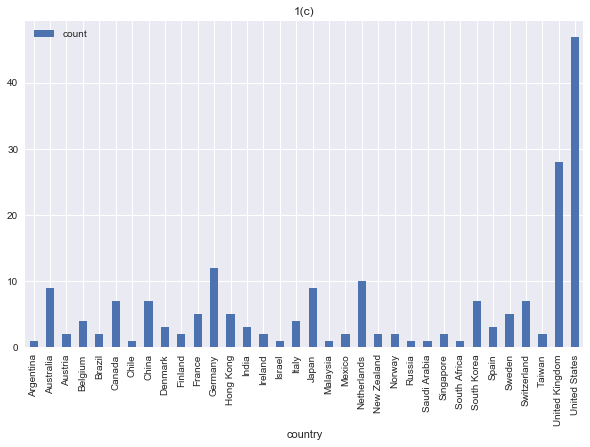

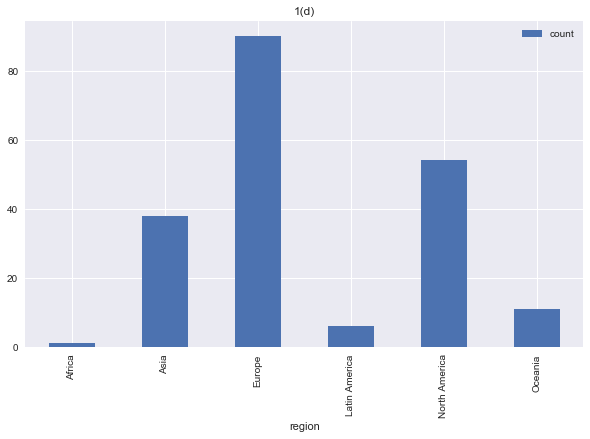

In [10]:
plot01=qs_country_grouped.plot(kind='bar', grid=True, figsize=(10, 6), title='1(c)')
plot02=qs_region_grouped.plot(kind='bar', grid=True, figsize=(10, 6), title='1(d)')

* Writing Data into a file

In [11]:
qs_top200.to_pickle("qs_top200_pickle")

# 2.Analysis of Times Higher Education Data

In [12]:
times_top200 = crawl_timeshighereducation(web_urls[1],200)

In [13]:
times_top200.head()

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
0,United Kingdom,0.38,1,11.2,20409,University of Oxford
1,United Kingdom,0.35,2,10.9,18389,University of Cambridge
2,United States,0.27,3,6.5,2209,California Institute of Technology
3,United States,0.22,3,7.5,15845,Stanford University
4,United States,0.34,5,8.7,11177,Massachusetts Institute of Technology


#### 2a. Best Universities: Student/Staff Ratio

In [14]:
times_top200.sort_values("student_staff_ratio",ascending=False).head(3)

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
99,Germany,0.13,100,77.9,35619,University of Bonn
124,Germany,0.16,125,74.5,10995,University of Mannheim
91,Germany,0.20,92,64.3,22390,Technical University of Berlin


#### 2b. Best Universities: International Student Ratio

In [15]:
times_top200.sort_values("percentage_international_students",ascending=False).head(3)

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
24,United Kingdom,0.71,25,12.2,10065,London School of Economics and Political Science
178,Luxembourg,0.57,179,14.6,4969,University of Luxembourg
37,Switzerland,0.55,38,11.2,9928,École Polytechnique Fédérale de Lausanne


#### 2c. Best Universities by Country

In [16]:
times_country_grouped = group_df(times_top200,"country","count")

display(times_country_grouped)

,count
country,
Australia,8
Austria,1
Belgium,4
Canada,6
China,7
Denmark,3
Finland,2
France,6
Germany,20


#### Plot

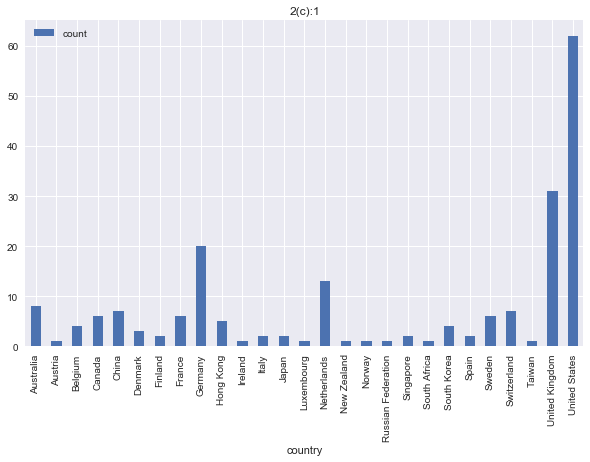

In [17]:
plot03=times_country_grouped.plot(kind='bar', grid=True, figsize=(10, 6), title='2(c):1')

* Writing Data into a file

In [18]:
times_top200.to_pickle("times_top200_pickle")

# 3.Merging Dataframe
#### We define 5 steps to match universities' name as much as we can

In [4]:
# Forming the dataframe df1 and df2
df1 = df_convert_index(qs_top200)
df1 = df1.add_prefix("qs_")

df2 = df_convert_index(times_top200)
df2 = df2.add_prefix("times_")

display(df1.head())
display(df2.head())

,qs_country,qs_rank,qs_region,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students
university_name,,,,,,,
Massachusetts Institute of Technology,United States,1,North America,2982,1679,3717,11067
Stanford University,United States,2,North America,4285,2042,3611,15878
Harvard University,United States,3,North America,4350,1311,5266,22429
California Institute of Technology,United States,4,North America,953,350,647,2255
University of Cambridge,United Kingdom,5,Europe,5490,2278,6699,18770


,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students
university_name,,,,,
University of Oxford,United Kingdom,0.38,1,11.2,20409
University of Cambridge,United Kingdom,0.35,2,10.9,18389
California Institute of Technology,United States,0.27,3,6.5,2209
Stanford University,United States,0.22,3,7.5,15845
Massachusetts Institute of Technology,United States,0.34,5,8.7,11177


### Step 1: Exact Matching of University Name and Form the Rest of Dataframe1

In [5]:
# Merging step 1
# find matching index in df2 from df1
df1_matching_idx = (df1.index).isin(df2.index)

# forming with exact match
df_merged_exact_match = pd.concat([df1[df1_matching_idx], df2], axis=1, join='inner')

# the rest
df1_rest = df1[~df1_matching_idx]
df_merged_exact_match

,qs_country,qs_rank,qs_region,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students
university_name,,,,,,,,,,,,
Massachusetts Institute of Technology,United States,1,North America,2982,1679,3717,11067,United States,0.34,5,8.7,11177
Stanford University,United States,2,North America,4285,2042,3611,15878,United States,0.22,3,7.5,15845
Harvard University,United States,3,North America,4350,1311,5266,22429,United States,0.26,6,8.9,20326
California Institute of Technology,United States,4,North America,953,350,647,2255,United States,0.27,3,6.5,2209
University of Cambridge,United Kingdom,5,Europe,5490,2278,6699,18770,United Kingdom,0.35,2,10.9,18389
University of Oxford,United Kingdom,6,Europe,6750,2964,7353,19720,United Kingdom,0.38,1,11.2,20409
Imperial College London,United Kingdom,8,Europe,3930,2071,8746,16090,United Kingdom,0.55,8,11.4,15857
University of Chicago,United States,9,North America,2449,635,3379,13557,United States,0.25,9,6.2,13525
"Nanyang Technological University, Singapore",Singapore,11,Asia,4338,2993,7251,25738,Singapore,0.31,52,16.3,25499


### Step 2: Form the rest of Dataframe 2

In [6]:
# Merging step 2
# find matching index in df1 from df2
df2_matching_idx = (df2.index).isin(df1.index)

# the rest
df2_rest = df2[~df2_matching_idx]
df2_rest

,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students
university_name,,,,,
ETH Zurich Swiss Federal Institute of Technology Zurich,Switzerland,0.38,10,14.6,19233
University College London,United Kingdom,0.49,16,10.5,30304
University of Edinburgh,United Kingdom,0.40,27,12.5,26759
University of Melbourne,Australia,0.40,32,26.6,42116
LMU Munich,Germany,0.15,34,15.6,36091
Kings College London,United Kingdom,0.41,36,12.0,23207
Karolinska Institute,Sweden,0.19,38,10.9,7424
University of Hong Kong,Hong Kong,0.42,40,18.0,18364
Hong Kong University of Science and Technology,Hong Kong,0.31,44,23.1,10214


### Step 3: Iterate Carefully through the Rest of Dataframe 1

In [9]:
# Merging step 3
# find matching index
university_list = []

for index, row in df1_rest.iterrows():  
    try:
        keyword = " ".join(index.split()[:3])
        if(keyword.endswith(",")):
            keyword = keyword[:-1]
    except IndexError:
        keyword = index.split()[0]
        
    if(keyword.startswith("The")):
        keyword = " ".join(index.split()[1:])
    elif(keyword.startswith("University of")):
        keyword = " ".join(index.split()[2:])
    elif(keyword.startswith("UCL")):
        keyword = "University College London"
    elif(keyword.startswith("King's College")):
        keyword = "Kings College"
    elif(keyword.startswith("KAIST")):
        keyword = "Korea Advanced Institute"
    elif(keyword.startswith("Ludwig")):
        keyword = "LMU"
    elif(keyword.endswith("Heidelberg")):
        keyword = "Heidelberg"
    elif(keyword.startswith("KIT")):
        keyword = "Karlsruhe"
    elif(keyword.startswith("Humboldt")):
        keyword = "Humboldt"
    elif(keyword.endswith("Montreal")):
        keyword = "Montreal"
    elif(keyword.startswith("Universite Pierre")):
        keyword = "Pierre"
    elif(keyword.startswith("Technische")):
        keyword = "Technical University of Berlin"
    elif(keyword.endswith("Catholique")):
        keyword = "Catholique"
    elif(keyword.startswith("ETH")):
        keyword = "ETH Zurich"
    elif(keyword.startswith("Freie")):
        keyword = "Free University"
    elif(keyword.startswith("Universite catholique")):
        keyword = "Louvain"
    elif(keyword.startswith("Eberhard Karls")):
        keyword = "Tubingen"
    elif(keyword.startswith("Albert-Ludwigs-Universitaet")):
        keyword = "Freiburg"
    elif(keyword.startswith("Scuola Superiore")):
        keyword = "Scuola Superiore"
    elif(keyword.startswith("Universitat Autonoma")):
        keyword = "Autonomous University"    
              
    matched_times_data = df2.filter(like=keyword, axis=0)
    matched_df2_rest = df2_rest.filter(like=keyword,axis=0)
    
    if(matched_times_data.empty is False):
        matched_qs_data = df1.loc[[index]]
        formed_qs_times = pd.concat([matched_qs_data.reset_index(),matched_times_data.reset_index()],axis=1)
        formed_qs_times = formed_qs_times.set_index(['university_name'])
        university_list.append(formed_qs_times.iloc[[0]])
    
    if(matched_df2_rest.empty is False):
        df2_rest = df2_rest.drop(matched_df2_rest.index)
        
qs_times_matched_1 = pd.concat(university_list)
#qs_times_matched_1.shape #(42)
qs_times_matched_1

,qs_country,qs_rank,qs_region,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students
university_name,,,,,,,,,,,,
"(UCL, University College London)",United Kingdom,7.0,Europe,6345.0,2554.0,14854.0,31080.0,United Kingdom,0.49,16,10.5,30304
"(ETH Zurich - Swiss Federal Institute of Technology, ETH Zurich Swiss Federal Institute of Technology Zurich)",Switzerland,10.0,Europe,2477.0,1886.0,7563.0,19815.0,Switzerland,0.38,10,14.6,19233
"(The Australian National University, Australian National University)",Australia,20.0,Oceania,1600.0,927.0,5551.0,14442.0,Australia,0.35,48,19.3,15986
"(King's College London, Kings College London)",United Kingdom,23.0,Europe,3650.0,1513.0,9451.0,23780.0,United Kingdom,0.41,36,12.0,23207
"(The University of Edinburgh, University of Edinburgh)",United Kingdom,23.0,Europe,4075.0,1553.0,10551.0,28040.0,United Kingdom,0.40,27,12.5,26759
"(The University of Hong Kong, University of Hong Kong)",Hong Kong,26.0,Asia,3012.0,2085.0,8230.0,20214.0,Hong Kong,0.42,40,18.0,18364
"(The University of Tokyo, University of Tokyo)",Japan,28.0,Asia,4514.0,254.0,2639.0,27279.0,Japan,0.10,46,6.7,26000
"(The Hong Kong University of Science and Technology, Hong Kong University of Science and Technology)",Hong Kong,30.0,Asia,1150.0,835.0,2921.0,10375.0,Hong Kong,0.31,44,23.1,10214
"(The University of Manchester, University of Manchester)",United Kingdom,34.0,Europe,4910.0,1653.0,13514.0,36670.0,United Kingdom,0.38,54,14.6,35318


### Step 4: Iterate Carefully through the rest of Dataframe 2

In [10]:
# Merging step 4
# find matching index
university_list = []

for index, row in df2_rest.iterrows():  
    try:
        keyword = " ".join(index.split()[:3])
        if(keyword.endswith(",")):
            keyword = keyword[:-1]
    except IndexError:
        keyword = index.split()[0]
        
    if(keyword.startswith("The")):
        keyword = " ".join(index.split()[1:])
    elif(keyword.startswith("University of North")):
        keyword = "North Carolina"
    elif(keyword.startswith("University of")):
        keyword = " ".join(index.split()[2:])
              
    matched_qs_data = df1_rest.filter(like=keyword, axis=0)
    
    if(matched_qs_data.empty is False):
        matched_times_data = df2.loc[[index]]
        formed_qs_times = pd.concat([matched_times_data.reset_index(),matched_qs_data.reset_index()],axis=1)
        formed_qs_times = formed_qs_times.set_index(['university_name'])
        university_list.append(formed_qs_times.iloc[[0]])
        
qs_times_matched_2 = pd.concat(university_list)
#qs_times_matched_2.shape #(1)
qs_times_matched_2

,times_country,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students,qs_country,qs_rank,qs_region,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students
university_name,,,,,,,,,,,,
"(University of North Carolina at Chapel Hill, University of North Carolina, Chapel Hill)",United States,0.08,56,9.7,34684,United States,80,North America,4083,524,1934,25373


### Step 5: Finally Merging Universities Data that Present in Both QS and Times

In [11]:
dataframes = [df_merged_exact_match, qs_times_matched_1, qs_times_matched_2]
combined_qs_times = pd.concat(dataframes)
combined_qs_times
combined_qs_times['qs_percentage_international_faculties'] = combined_qs_times.qs_total_international_faculty_members/combined_qs_times.qs_total_faculty_members

# 4. Exploratory Data Analysis

#### Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

### Relation between two variables
We will use the following table to reveal some phenomenon

In [27]:
combined_qs_times.corr()

,qs_rank,qs_total_faculty_members,qs_total_international_faculty_members,qs_total_international_students,qs_total_students,times_percentage_international_students,times_rank,times_student_staff_ratio,times_total_students,qs_percentage_international_faculties
qs_rank,1.000000,-0.324609,-0.496157,-0.254126,-0.013007,-0.282931,0.654184,0.315411,-0.031831,-0.343369
qs_total_faculty_members,-0.324609,1.000000,0.643402,0.426392,0.603387,-0.140945,-0.335806,-0.056206,0.571223,-0.115670
qs_total_international_faculty_members,-0.496157,0.643402,1.000000,0.585157,0.296191,0.318941,-0.347260,-0.067638,0.267899,0.590041
qs_total_international_students,-0.254126,0.426392,0.585157,1.000000,0.635719,0.395329,-0.231519,0.216386,0.555439,0.303949
qs_total_students,-0.013007,0.603387,0.296191,0.635719,1.000000,-0.288146,-0.122535,0.317958,0.940092,-0.209314
times_percentage_international_students,-0.282931,-0.140945,0.318941,0.395329,-0.288146,1.000000,-0.205433,-0.067572,-0.301277,0.647131
times_rank,0.654184,-0.335806,-0.347260,-0.231519,-0.122535,-0.205433,1.000000,0.055889,-0.150627,-0.137290
times_student_staff_ratio,0.315411,-0.056206,-0.067638,0.216386,0.317958,-0.067572,0.055889,1.000000,0.275606,-0.022642
times_total_students,-0.031831,0.571223,0.267899,0.555439,0.940092,-0.301277,-0.150627,0.275606,1.000000,-0.202037
qs_percentage_international_faculties,-0.343369,-0.115670,0.590041,0.303949,-0.209314,0.647131,-0.137290,-0.022642,-0.202037,1.000000


#### Does the university with higher proportion of international students also have higher proportion of international faculties?
In the result above, we could see the coefficient coefficient of % of international students and % of international faculties is 0.642269, which tells us that a university with more percentage of international students tends to have more percentage of international faculties (Like EPFL). 

However, we could also see some outliers in the plot. For example, there're some schools with lower proportion of international students but with higher proportion of international faculties, and it turns out to be the two universities in Switzerland: University of Zurich and University of Bern

University with fewer than 20% of international students but with more than 50% of international faculties
University of Zurich
University of Bern


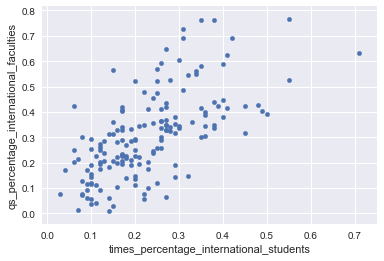

In [32]:
combined_qs_times.plot.scatter(x='times_percentage_international_students', y='qs_percentage_international_faculties');
print('University with fewer than 20% of international students but with more than 50% of international faculties')
for university in combined_qs_times.index[(combined_qs_times.qs_percentage_international_faculties > 0.5) & \
                                          (combined_qs_times.times_percentage_international_students <= 0.2)]:
    print(university)

#### Does higher # of international faculties help the ranking? (Not sure whether to put in report)
We could see generally this is true, and now we observer the outlier (the one with very high ranking but with few number of international faculties). We could find generally there are two kinds of groups. The first group is the universities in Asia, and the other group is the universities in USA.

California Institute of Technology
Princeton University
Duke University
Kyoto University
Seoul National University
Carnegie Mellon University
('The University of Tokyo', 'University of Tokyo')
('KAIST - Korea Advanced Institute of Science & Technology', 'Korea Advanced Institute of Science and Technology')


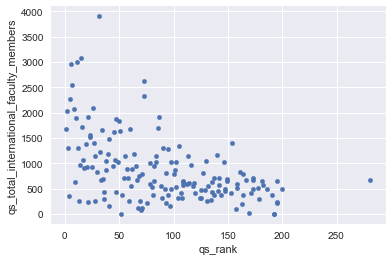

In [35]:
combined_qs_times.plot.scatter(x='qs_rank', y='qs_total_international_faculty_members');
for university in combined_qs_times.index[(combined_qs_times.qs_rank < 50) & \
                                          (combined_qs_times.qs_total_international_faculty_members < 500)]:
    print(university)

#### Does the # of students move with # of faculties?
The correlation between these two attributes is 0.59, and it reveals a natural result: If there are more students, we need more faculties. And there are some outliers with roughly 60000 students and fewer than 3000 faculties.

University with fewer than 4000 faculties and more than 50000 students:
Monash University
University of Washington
Texas A&M University


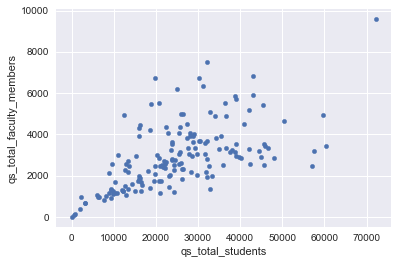

In [39]:
combined_qs_times.plot.scatter(x='qs_total_students', y='qs_total_faculty_members');
print('University with fewer than 4000 faculties and more than 50000 students:')
for university in combined_qs_times.index[(combined_qs_times.qs_total_students > 50000) & (combined_qs_times.qs_total_faculty_members < 4000)]:
    print(university)

#### How does QS ranking and Times ranking differ?
We could see an interesting phenomenon: There's no big difference within the top 30 universities in QS ranking and Times ranking (we could see an obvious line there), and after 30, the ranking starts to differ a lot.

In the following we show the universities which are top 100 in QS but more than 150 in Times, and we can see the universities are mostly in Asia (Only KTH is in Europe). On the other hand, the universities which are top 100 in Times but more than 150 in QS are in Europe and USA.

University which is top 100 in QS but more than 150 in Times
Shanghai Jiao Tong University
National Taiwan University
Zhejiang University
Lomonosov Moscow State University
KTH Royal Institute of Technology
('The University of Auckland', 'University of Auckland')
('The Hong Kong Polytechnic University', 'Hong Kong Polytechnic University')

University which is top 100 in Times but more than 150 in QS
University of Minnesota
University of California, Irvine
Dartmouth College
('Eberhard Karls Universitat Tubingen', 'University of Tubingen')
('Albert-Ludwigs-Universitaet Freiburg', 'University of Freiburg')
('King Fahd University of Petroleum & Minerals', 'Kings College London')
('Technische Universitat Dresden', 'Technical University of Berlin')


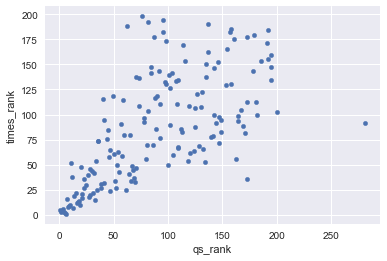

In [40]:
combined_qs_times.plot.scatter(x='qs_rank', y='times_rank');

print('University which is top 100 in QS but more than 150 in Times')
for university in combined_qs_times.index[(combined_qs_times.qs_rank < 100) & (combined_qs_times.times_rank > 150)]:
    print(university)
print()
print('University which is top 100 in Times but more than 150 in QS')
for university in combined_qs_times.index[(combined_qs_times.times_rank < 100) & (combined_qs_times.qs_rank > 150)]:
    print(university)

#### Does Times give worse ranking to universities in Asia?
This question is naturally asked based on the observation above. We use rank_qs - rank_times to observe the result and we can see that only one university gets higher rank in Times: Peking University

Asia University with higher ranking in Times
Peking University
('King Fahd University of Petroleum & Minerals', 'Kings College London')


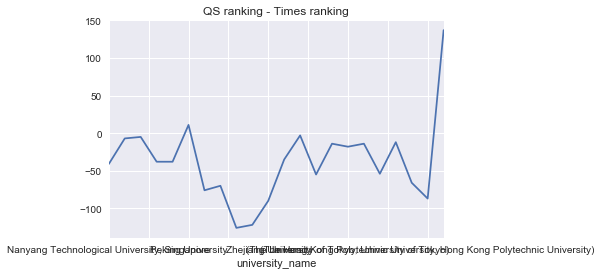

In [43]:
(combined_qs_times.qs_rank[combined_qs_times.qs_region == 'Asia'] - combined_qs_times.times_rank[combined_qs_times.qs_region == 'Asia']).plot(x = 'QS ranking',\
                                                                                                           title = 'QS ranking - Times ranking')
print('Asia University with higher ranking in Times')
for university in combined_qs_times.index[(combined_qs_times.times_rank < combined_qs_times.qs_rank) & (combined_qs_times.qs_region == 'Asia')]:
    print(university)

#### Calculate the proportions of university in top 200 by region

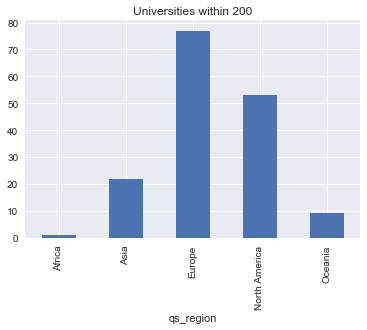

In [46]:
combined_qs_times.groupby('qs_region').size().plot('bar', title = 'Universities within 200')

# 5. Best university taking in consideration both rankings.
In this question, we use harmonic mean of two rankings as the final ranking:
$$ \overline{x} = \frac{2x_1x_2}{(x_1 + x_2)} $$
the reason to use harmonic mean is that we want put more emphasis on better ranking. The property of harmonic mean is that the mean would be more close to the one with small number (i.e. higher ranking)

We don't use regression to combine the ranking, and the reason is that we don't have too many features in our dataset (at least we know both rankings are based on lots of other attributes such as Citations per Faculty, Academic Reputation, Employer Reputation ... etc), and hence use regression to calculate the ranking would cause underfitting.

In [50]:
harmonic_rank = (2 * combined_qs_times.qs_rank * combined_qs_times.times_rank)/(combined_qs_times.qs_rank + combined_qs_times.times_rank)
# shift the highest ranking to 1
harmonic_rank = harmonic_rank - (harmonic_rank.min() - 1)

# create the dataframe to show the result
final_rank = pd.DataFrame(index = combined_qs_times.index)
final_rank['final ranking'] = harmonic_rank.round().astype(int)
final_rank.sort_values('final ranking')

,final ranking
university_name,
Massachusetts Institute of Technology,1
University of Oxford,1
Stanford University,2
University of Cambridge,2
Harvard University,3
California Institute of Technology,3
Imperial College London,7
University of Chicago,8
Princeton University,8
